In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization
from scipy import interpolate
from scipy import stats
import plotly.express as px
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# On avge, 252 trading days a year
NUM_TRADING_DAYS = 252

# Generate random w (diff. portfolios)
NUM_PORTFOLIOS = 10000

# Our portfolio stocks
stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']

# Historical data - define START, END dates
start_date = '2010-01-01'
end_date = '2023-10-01'

In [ ]:
merged = pd.read_excel("merged.xlsx", index_col=0)
merged



,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Lower_Bollinger,AAPL_MACD,AAPL_Open,AAPL_RSI,AAPL_SMA,...,NVDA_Low,NVDA_Lower_Bollinger,NVDA_MACD,NVDA_Open,NVDA_RSI,NVDA_SMA,NVDA_Sentiment_score,NVDA_Upper_Bollinger,NVDA_Volatility,NVDA_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-0.917649,-0.940025,-0.062172,-0.940606,-0.940167,-0.945018,-0.259339,-0.940594,-1.379814,-0.941188,...,-0.634826,-0.640303,-0.178014,-0.634267,-1.752772,-0.637586,-0.186317,-0.637832,-0.541462,0.933603
2010-01-05,-0.917442,-0.939779,0.034729,-0.939889,-0.939582,-0.945018,-0.259339,-0.939815,-1.379814,-0.941188,...,-0.634027,-0.640303,-0.178014,-0.634494,-1.752772,-0.637586,-0.186317,-0.637832,-0.541462,0.705872
2010-01-06,-0.919351,-0.942046,-0.953747,-0.940126,-0.941264,-0.945018,-0.259339,-0.939961,-1.379814,-0.941188,...,-0.633640,-0.640303,-0.178014,-0.633660,-1.752772,-0.637586,-0.186317,-0.637832,-0.541462,0.452922
2010-01-07,-0.919570,-0.942306,-0.165785,-0.942251,-0.942408,-0.945018,-0.259339,-0.941712,-1.379814,-0.941188,...,-0.634156,-0.640303,-0.178014,-0.633584,-1.752772,-0.637586,-0.186317,-0.637832,-0.541462,0.130286
2010-01-08,-0.918786,-0.941375,0.310473,-0.942251,-0.942401,-0.945018,-0.259339,-0.942677,-1.379814,-0.941188,...,-0.634465,-0.640303,-0.178014,-0.634646,-1.752772,-0.637586,-0.186317,-0.637832,-0.541462,-0.091297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-13,2.266052,2.247853,-0.639089,2.269481,2.273524,2.287450,-0.081398,2.298654,0.030054,2.196547,...,3.990453,4.063889,1.117679,4.068563,0.654903,3.894813,0.830900,3.744573,2.118819,-0.104196
2023-10-16,2.263650,2.245432,-0.102915,2.216983,2.242811,2.294134,0.216069,2.211614,0.749358,2.205579,...,3.952483,4.083356,1.494220,3.876696,0.887438,3.925509,0.830900,3.784150,2.222884,-0.419320
2023-10-17,2.234651,2.216199,-0.554564,2.204826,2.210590,2.304669,0.482157,2.209750,0.740543,2.214558,...,3.701549,4.095437,1.631961,3.769182,0.086638,3.936294,0.830900,3.793855,2.222988,0.972204


In [ ]:
import numpy as np
import pandas as pd

stock_dict = {}
for stock in stocks:
    new_df = merged.filter(regex=f'{stock}_')
    stock_dict[f"{stock}"] = new_df

print(stock_dict)

{'AAPL':             AAPL_Adj Close  AAPL_Close  AAPL_Daily_Return  AAPL_High  \
Date                                                                   
2010-01-04       -0.917649   -0.940025          -0.062172  -0.940606   
2010-01-05       -0.917442   -0.939779           0.034729  -0.939889   
2010-01-06       -0.919351   -0.942046          -0.953747  -0.940126   
2010-01-07       -0.919570   -0.942306          -0.165785  -0.942251   
2010-01-08       -0.918786   -0.941375           0.310473  -0.942251   
...                    ...         ...                ...        ...   
2023-10-13        2.266052    2.247853          -0.639089   2.269481   
2023-10-16        2.263650    2.245432          -0.102915   2.216983   
2023-10-17        2.234651    2.216199          -0.554564   2.204826   
2023-10-18        2.210454    2.191807          -0.476660   2.189353   
2023-10-19        2.203435    2.184731          -0.183298   2.194142   

            AAPL_Low  AAPL_Lower_Bollinger  AAPL_MACD 

In [ ]:
AAPL_test= stock_dict["AAPL"]
AAPL_test

,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Lower_Bollinger,AAPL_MACD,AAPL_Open,AAPL_RSI,AAPL_SMA,AAPL_Sentiment_score,AAPL_Upper_Bollinger,AAPL_Volatility,AAPL_Volume
Date,,,,,,,,,,,,,,
2010-01-04,-0.917649,-0.940025,-0.062172,-0.940606,-0.940167,-0.945018,-0.259339,-0.940594,-1.379814,-0.941188,-1.183856,-0.943664,-0.793046,1.126903
2010-01-05,-0.917442,-0.939779,0.034729,-0.939889,-0.939582,-0.945018,-0.259339,-0.939815,-1.379814,-0.941188,-1.183856,-0.943664,-0.793046,1.616857
2010-01-06,-0.919351,-0.942046,-0.953747,-0.940126,-0.941264,-0.945018,-0.259339,-0.939961,-1.379814,-0.941188,-1.183856,-0.943664,-0.793046,1.391549
2010-01-07,-0.919570,-0.942306,-0.165785,-0.942251,-0.942408,-0.945018,-0.259339,-0.941712,-1.379814,-0.941188,-1.183856,-0.943664,-0.793046,1.051724
2010-01-08,-0.918786,-0.941375,0.310473,-0.942251,-0.942401,-0.945018,-0.259339,-0.942677,-1.379814,-0.941188,-1.183856,-0.943664,-0.793046,0.918018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-13,2.266052,2.247853,-0.639089,2.269481,2.273524,2.287450,-0.081398,2.298654,0.030054,2.196547,1.096190,2.113190,0.687019,-0.876402
2023-10-16,2.263650,2.245432,-0.102915,2.216983,2.242811,2.294134,0.216069,2.211614,0.749358,2.205579,1.096190,2.124281,0.724461,-0.871465
2023-10-17,2.234651,2.216199,-0.554564,2.204826,2.210590,2.304669,0.482157,2.209750,0.740543,2.214558,1.096190,2.131875,0.712209,-0.848672


In [ ]:
training_list = ["AAPL_Daily_Return", "AAPL_Adj Close", "AAPL_Volume", "AAPL_Sentiment_score"]

AAPL_test = AAPL_test.loc[:, training_list].values
# AAPL_test = AAPL_test.loc[:, training_list]
print(AAPL_test)

[[-0.06217191 -0.91764919  1.12690267 -1.18385563]
 [ 0.03472919 -0.91744202  1.61685665 -1.18385563]
 [-0.95374716 -0.91935141  1.39154934 -1.18385563]
 ...
 [-0.55456404  2.23465073 -0.84867234  1.09618958]
 [-0.47665987  2.21045382 -0.86128634  1.09618958]
 [-0.18329771  2.20343504 -0.84073028  1.09618958]]


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range=(0,1))
# training_set_scaled = sc.fit_transform(training_set)

X = []
y = []

# print(len(AAPL_test.index)) #3474
length = len(AAPL_test)
print(length)
sequence_length = 50

for i in range(length - sequence_length):
    X.append(AAPL_test[i:i + sequence_length])
    y.append(AAPL_test[i + sequence_length, 0])

X, y = np.array(X), np.array(y)

print(y)

3474
[-0.14457261  0.07037001 -0.66097898 ... -0.55456404 -0.47665987
 -0.18329771]


In [ ]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# creatiopn of validation set from train data
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

In [ ]:
len(y_train)

2192

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import regularizers

Epoch 1/50
69/69 [==============================] - 15s 125ms/step - loss: 1.1621 - val_loss: 1.1136
Epoch 2/50
69/69 [==============================] - 8s 115ms/step - loss: 1.0824 - val_loss: 1.0790
Epoch 3/50
69/69 [==============================] - 7s 106ms/step - loss: 1.0591 - val_loss: 1.0673
Epoch 4/50
69/69 [==============================] - 8s 116ms/step - loss: 1.0493 - val_loss: 1.0598
Epoch 5/50
69/69 [==============================] - 7s 95ms/step - loss: 1.0407 - val_loss: 1.0535
Epoch 6/50
69/69 [==============================] - 8s 116ms/step - loss: 1.0327 - val_loss: 1.0600
Epoch 7/50
69/69 [==============================] - 7s 96ms/step - loss: 1.0284 - val_loss: 1.0406
Epoch 8/50
69/69 [==============================] - 8s 113ms/step - loss: 1.0223 - val_loss: 1.0503
Epoch 9/50
69/69 [==============================] - 8s 116ms/step - loss: 1.0207 - val_loss: 1.0425
Epoch 10/50
69/69 [==============================] - 7s 96ms/step - loss: 1.0153 - val_loss: 1.0332
E

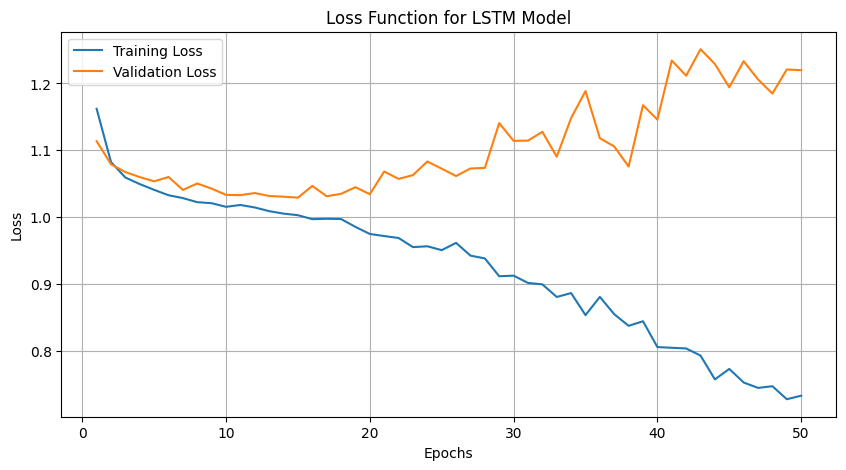

In [ ]:
# 7 features
model = Sequential()

model.add(LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape= (sequence_length, 4)))
model.add(LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(25, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, kernel_regularizer=regularizers.l2(0.001)))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs= 50, batch_size=32)

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plot the loss function
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Loss Function for LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# MSE
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')

y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

22/22 [==============================] - 1s 31ms/step - loss: 1.9926
Test loss: 1.992633581161499
22/22 [==============================] - 1s 30ms/step
1.3987958446137883


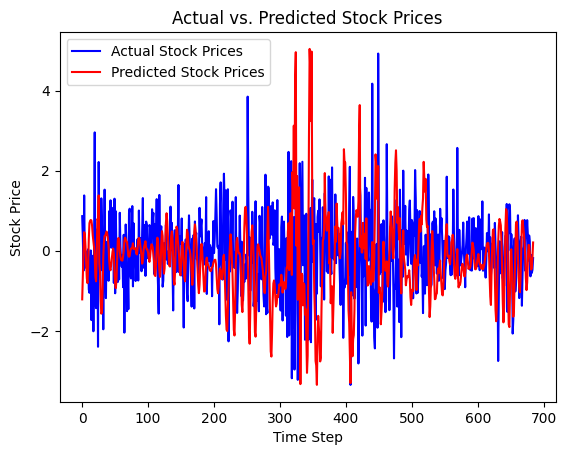

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have y_test_original_scale and y_pred_original_scale

# Create a range of indices for plotting
indices = range(len(y_test))

# Plot the actual stock prices (in blue)
plt.plot(indices, y_test, label="Actual Stock Prices", color='blue')

# Plot the predicted stock prices (in red)
plt.plot(indices, y_pred, label="Predicted Stock Prices", color='red')

# Add labels and legend
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()

# Show the plot
plt.show()

In [ ]:
!pip install scikeras

In [ ]:
import tensorflow as tf
from scikeras.wrappers import KerasRegressor

In [ ]:
def create_lstm_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(sequence_length, 4)))
    model.add(Dense(1, activation='relu'))
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    print("Creating model in function")
    return model
# initialised legacy optimizer due to MacOS constraints

# Create the LSTM model
lstm_model = KerasRegressor(model=create_lstm_model, verbose=0, batch_size=10, learning_rate=0.001, units=50)
print("Created model!")




Created model!


In [ ]:
# Specify hyperparameter values to search
param_grid = {
    'units': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [50, 100],
    'batch_size': [30, 50]
}

# Perform grid search
grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=3)
print("Initialised GridSearchCV")
grid_search.fit(X_train, y_train)  # X_train and y_train are your training data

# Get the best hyperparameters
best_units = grid_search.best_params_['units']
best_learning_rate = grid_search.best_params_['learning_rate']
best_epochs = grid_search.best_params_['epochs']
best_batch_size = grid_search.best_params_['batch_size']

print(best_units, best_learning_rate, best_epochs, best_batch_size)

Initialised GridSearchCV
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Creating model in function
Cre

In [ ]:
# Train the final model with the best hyperparameters

final_model = create_lstm_model(units=best_units, learning_rate=best_learning_rate)
model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=best_epochs, batch_size=best_batch_size)

In [ ]:
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
import matplotlib.pyplot as plt

# Create a range of indices for plotting
indices = range(len(y_test))

# Plot the actual stock prices (in blue)
plt.plot(indices, y_test, label="Actual Stock Prices", color='blue')

# Plot the predicted stock prices (in red)
plt.plot(indices, y_pred, label="Predicted Stock Prices", color='red')

# Add labels and legend
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()

# Show the plot
plt.show()